# World Navigation with DQN

In this exercise you will play a world navigation game with Deep Q-Networks. The agent learn to solve a navigation task in a basic grid world. It will be built upon the simple one layer Q-network you created in Exercise 1.

In order to transform an ordinary Q-Network into a DQN you will be making the following improvements:
1. Going from a single-layer network to a multi-layer convolutional network.
2. Implementing Experience Replay, which will allow our network to train itself using stored memories from it's experience.
3. Utilizing a second "target" network, which we will use to compute target Q-values during our updates.

You will also implement two simple additional improvements to the DQN architecture, Double DQN and Dueling DQN, that allow for improved performance, stability, and faster training time. In the end you will have a network that can tackle a number of challenging Atari games, and we will demonstrate how to train the DQN to learn a basic navigation task.

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

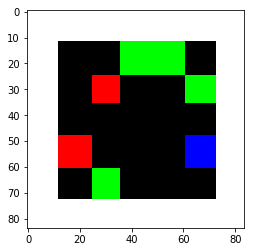

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)

In [17]:
dir(env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'actions',
 'checkGoal',
 'moveChar',
 'newPosition',
 'objects',
 'partial',
 'renderEnv',
 'reset',
 'sizeX',
 'sizeY',
 'state',
 'step']

Above is an example of a starting environment in our simple game. The game environment outputs 84x84x3 color images, and uses function calls as similar to the OpenAI gym as possible. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). 

At the start of each episode all squares are randomly placed within a 5x5 grid-world. The agent has 50 steps to achieve as large a reward as possible. Because they are randomly positioned, the agent needs to do more than simply learn a fixed path, as was the case in the FrozenLake environment from Exercise 1. Instead the agent must learn a notion of spatial relationships between the blocks. 

*Feel free to adjust the size of the gridworld (default 5). Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.*

### Addition 1: Convolutional Layers

The first major addition to make DQNs work is to use convolutional layers to set up the networks. We are now familiar with convolutional layers after assignment `1-3`. For more information, see the [Tensorflow documentation](https://www.tensorflow.org/api_docs/).

### Addition 2: Experience Replay

The second major addition to make DQNs work is Experience Replay. The basic idea is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. 

Each of these experiences are stored as a tuple of *(state,action,reward,next state)*. The Experience Replay buffer stores a fixed number of recent memories, and as new ones come in, old ones are removed. When the time comes to train, we simply draw a uniform batch of random memories from the buffer, and train our network with them. 

For our DQN, we build a simple class that allows us to store experies and sample them randomly to train the network:

In [3]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

This is a simple function to resize our game frames:

In [4]:
def processState(states):
    return np.reshape(states,[21168]) # 84 x 84 x 3

### Addition 3: Separate Target Network

The third major addition to the DQN that makes it unique is the utilization of a second network during the training procedure. This second network is used to generate the target-Q values that will be used to compute the loss for every action during training. Why not use just use one network for both estimations? The issue is that at every step of training, the Q-network’s values shift, and if we are using a constantly shifting set of values to adjust our network values, then the value estimations can easily spiral out of control. The network can become destabilized by falling into feedback loops between the target and estimated Q-values. In order to mitigate that risk, the target network’s weights are fixed, and only periodically or slowly updated to the primary Q-networks values. In this way training can proceed in a more stable manner.

These functions allow us to update the parameters of our target network with those of the primary network.

In [5]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

With the additions above, we have everything we need to replicate the DQN.  

### Dueling DQN

In order to explain the reasoning behind the architecture changes that Dueling DQN makes, we need to first explain some a few additional reinforcement learning terms. The Q-values that we have been discussing so far correspond to how good it is to take a certain action given a certain state. This can be written as `Q(s,a)`. This action given state can actually be decomposed into two more fundamental notions of value. The first is the value function `V(s)`, which says simple how good it is to be in any given state. The second is the advantage function `A(a)`, which tells how much better taking a certain action would be compared to the others. We can then think of `Q` as being the combination of `V` and `A`. More formally:

$$ Q(s,a) =V(s) + A(a) $$

The goal of Dueling DQN is to have a network that separately computes the advantage and value functions, and combines them back into a single Q-function only at the final layer. It may seem somewhat pointless to do this at first glance. Why decompose a function that we will just put back together? The key to realizing the benefit is to appreciate that our reinforcement learning agent may not need to care about both value and advantage at any given time. We can achieve more robust estimates of state value by decoupling it from the necessity of being attached to specific actions.

### Implementing the network itself

In [48]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        #We use slim.conv2d to set up our network 
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        ################################################################################
        # TODO: Implement Dueling DQN                                                  #
        # We take the output from the final convolutional layer i.e. self.conv4 and    #
        # split it into separate advantage and value streams.                          #
        # Outout: self.Advantage, self.Value                                           #
        # Hint: Refer to Fig.1 in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)  #
        #       In implementation, use tf.split to split into two branches. You may    #
        #       use xavier_initializer for initializing the two additional linear      #
        #       layers.                                                                # 
        ################################################################################
        pass
        init = tf.contrib.layers.xavier_initializer()
        V_split, A_split = tf.split(self.conv4, 2, 3)
#         V_split = tf.reshape(V_split, [-1, h_size])
#         A_split = tf.reshape(A_split, [-1, h_size])
        V_split = slim.flatten(V_split)
        A_split = slim.flatten(A_split)
        self.Value = tf.layers.dense(V_split, 1, kernel_initializer=init)
        self.Advantage = tf.layers.dense(A_split, env.actions, kernel_initializer=init)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        #Then combine them together to get our final Q-values. 
        #Please refer to Equation (9) in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        ################################################################################
        # TODO:                                                                        #
        # Obtain the loss (self.loss) by taking the sum of squares difference          #
        # between the target and prediction Q values.                                  #
        ################################################################################
        pass
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        self.loss = tf.reduce_sum(tf.square(self.Q-self.targetQ))
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Training the network

Setting all the training parameters

In [46]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 5000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

### Double DQN

The main intuition behind Double DQN is that the regular DQN often overestimates the Q-values of the potential actions to take in a given state. While this would be fine if all actions were always overestimates equally, there was reason to believe this wasn’t the case. You can easily imagine that if certain suboptimal actions regularly were given higher Q-values than optimal actions, the agent would have a hard time ever learning the ideal policy. In order to correct for this, the authors of DDQN paper propose a simple trick: instead of taking the max over Q-values when computing the target-Q value for our training step, we use our primary network to chose an action, and our target network to generate the target Q-value for that action. By decoupling the action choice from the target Q-value generation, we are able to substantially reduce the overestimation, and train faster and more reliably. Below is the new DDQN equation for updating the target value.


$$ Q \text{-}target = r + γQ(s',\arg \max(Q(s’,a,\theta),\theta')) $$

In [52]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            total_steps += 1
            
            ################################################################################
            # TODO: Save the experience to our episode buffer.                             #
            # You will need to do the following:                                           #
            # (1) Get new state s1 (resized), reward r and done d from a                   #
            # (2) Add experience to episode buffer. Hint: experience includes              #
            #     s, a, r, s1 and d.                                                       #
            ################################################################################
            pass
            s1, r, d = env.step(a)
            s1 = processState(s1)
            episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ##############################################################################
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    
                    ################################################################################
                    # TODO: Implement Double-DQN                                                   #
                    # (1) Get a random batch of experiences via experience_buffer class            #
                    #                                                                              #
                    # (2) Perform the Double-DQN update to the target Q-values                     #
                    #     Hint: Use mainQN and targetQN separately to chose an action and predict  #
                    #     the Q-values for that action.                                            #
                    #     Then compute targetQ based on Double-DQN equation                        #
                    #                                                                              #
                    # (3) Update the primary network with our target values                        #
                    ################################################################################ 
                    pass
                    exp_batch = myBuffer.sample(batch_size)
                    s_batch = np.vstack(exp_batch[:, 0])
                    a_batch = exp_batch[:, 1]
                    r_batch = exp_batch[:, 2]
                    s1_batch = np.vstack(exp_batch[:, 3])
                    d_batch = exp_batch[:, 4]
#                     print (exp_batch.shape, s_batch.shape, a_batch.shape, r_batch.shape, s1_batch.shape, d_batch.shape)
                    mainQN_predict = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:s1_batch})
                    targetQN_Qout = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:s1_batch})
                    targetQN_Q_value = targetQN_Qout[range(batch_size), mainQN_predict]
#                     end_mat = -(d_batch-1)
#                     target_Q_value = r_batch + y*targetQN_Q_value*end_mat
                    target_Q_value = r_batch + y*targetQN_Q_value
                    sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:s_batch,\
                                                           mainQN.targetQ:target_Q_value,\
                                                           mainQN.actions:a_batch})
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
                           
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print("Episode",i,"reward:",np.mean(rList[-10:]))
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Mean reward per episode: " + str(sum(rList)/num_episodes))

Saved Model
Episode 9 reward: 2.1
Episode 19 reward: 1.2
Episode 29 reward: 2.2
Episode 39 reward: 1.5
Episode 49 reward: 1.6
Episode 59 reward: 2.1
Episode 69 reward: 3.3
Episode 79 reward: 1.8
Episode 89 reward: 2.1
Episode 99 reward: 2.4
Episode 109 reward: 2.1
Episode 119 reward: 1.4
Episode 129 reward: 2.0
Episode 139 reward: 1.9
Episode 149 reward: 1.1
Episode 159 reward: 1.9
Episode 169 reward: 0.5
Episode 179 reward: 1.2
Episode 189 reward: 2.2
Episode 199 reward: 2.9
Episode 209 reward: 3.0
Episode 219 reward: 0.8
Episode 229 reward: 1.8
Episode 239 reward: 1.8
Episode 249 reward: 1.1
Episode 259 reward: 3.0
Episode 269 reward: 1.6
Episode 279 reward: 3.1
Episode 289 reward: 2.3
Episode 299 reward: 2.7
Episode 309 reward: 1.2
Episode 319 reward: 2.2
Episode 329 reward: 2.0
Episode 339 reward: 2.5
Episode 349 reward: 2.6
Episode 359 reward: 1.4
Episode 369 reward: 1.6
Episode 379 reward: 1.9
Episode 389 reward: 2.0
Episode 399 reward: 2.2
Episode 409 reward: 2.2
Episode 419 rew

It takes about 40 minutes to train 5000 episodes in Lab 4 machines. Mean reward per episode (50 steps) should be around 20

### Checking network learning

Mean reward over time

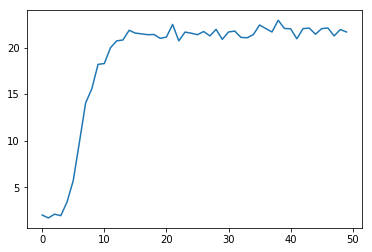

In [53]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

## Inline Question:
Try a basic DQN without Dueling DQN and Double DQN (i.e. only one single network, no decomposition of the Q-function). You don't need to provide detailed source, just some quantitative comparison is OK (e.g. by comparing the mean reward). **

**Your answer:** *only single network has only 14.476, while DQN with Dueling DQN and Double DQN achieved 18.667 under the same hypyerparamter*

In [55]:
class Qnetwork_single():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        #We use slim.conv2d to set up our network 
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        ################################################################################
        # TODO: Implement Dueling DQN                                                  #
        # We take the output from the final convolutional layer i.e. self.conv4 and    #
        # split it into separate advantage and value streams.                          #
        # Outout: self.Advantage, self.Value                                           #
        # Hint: Refer to Fig.1 in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)  #
        #       In implementation, use tf.split to split into two branches. You may    #
        #       use xavier_initializer for initializing the two additional linear      #
        #       layers.                                                                # 
        ################################################################################
        pass
        init = tf.contrib.layers.xavier_initializer()
        
        self.Qout = tf.layers.dense(slim.flatten(self.conv4), env.actions, kernel_initializer=init)
        self.predict = tf.argmax(self.Q,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        self.loss = tf.reduce_sum(tf.square(self.Q-self.targetQ))
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [58]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 5000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn_single" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [61]:

tf.reset_default_graph()
singleQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(singleQN.predict,feed_dict={singleQN.scalarInput:[s]})[0]
            total_steps += 1
            
            ################################################################################
            # TODO: Save the experience to our episode buffer.                             #
            # You will need to do the following:                                           #
            # (1) Get new state s1 (resized), reward r and done d from a                   #
            # (2) Add experience to episode buffer. Hint: experience includes              #
            #     s, a, r, s1 and d.                                                       #
            ################################################################################
            pass
            s1, r, d = env.step(a)
            s1 = processState(s1)
            episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    
                    ################################################################################
                    # TODO: Implement Double-DQN                                                   #
                    # (1) Get a random batch of experiences via experience_buffer class            #
                    #                                                                              #
                    # (2) Perform the Double-DQN update to the target Q-values                     #
                    #     Hint: Use mainQN and targetQN separately to chose an action and predict  #
                    #     the Q-values for that action.                                            #
                    #     Then compute targetQ based on Double-DQN equation                        #
                    #                                                                              #
                    # (3) Update the primary network with our target values                        #
                    ################################################################################ 
                    pass
                    exp_batch = myBuffer.sample(batch_size)
                    s_batch = np.vstack(exp_batch[:, 0])
                    a_batch = exp_batch[:, 1]
                    r_batch = exp_batch[:, 2]
                    s1_batch = np.vstack(exp_batch[:, 3])
                    d_batch = exp_batch[:, 4]
                    singleQN_predict, singleQN_Qout = sess.run([singleQN.predict, singleQN.Qout], feed_dict={singleQN.scalarInput:s1_batch})
                    target_Q_value = r_batch + y*np.max(singleQN_Qout, axis=1)
                    sess.run(singleQN.updateModel, feed_dict={singleQN.scalarInput:s_batch,\
                                                           singleQN.targetQ:target_Q_value,\
                                                           singleQN.actions:a_batch})
                           
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print("Episode",i,"reward:",np.mean(rList[-10:]))
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Mean reward per episode: " + str(sum(rList)/num_episodes))

Saved Model
Episode 9 reward: 1.6
Episode 19 reward: 3.0
Episode 29 reward: 0.7
Episode 39 reward: 2.2
Episode 49 reward: 1.7
Episode 59 reward: 3.6
Episode 69 reward: 2.4
Episode 79 reward: 3.2
Episode 89 reward: 2.7
Episode 99 reward: 1.5
Episode 109 reward: 0.5
Episode 119 reward: 1.5
Episode 129 reward: 1.2
Episode 139 reward: 2.1
Episode 149 reward: 2.2
Episode 159 reward: 1.0
Episode 169 reward: 2.8
Episode 179 reward: 1.6
Episode 189 reward: 1.0
Episode 199 reward: 1.2
Episode 209 reward: 2.0
Episode 219 reward: 1.0
Episode 229 reward: 2.3
Episode 239 reward: 1.0
Episode 249 reward: 0.9
Episode 259 reward: 1.8
Episode 269 reward: 1.7
Episode 279 reward: 1.6
Episode 289 reward: 1.2
Episode 299 reward: 1.7
Episode 309 reward: 0.8
Episode 319 reward: 1.8
Episode 329 reward: 2.4
Episode 339 reward: 2.5
Episode 349 reward: 1.4
Episode 359 reward: 2.2
Episode 369 reward: 1.3
Episode 379 reward: 1.7
Episode 389 reward: 1.2
Episode 399 reward: 1.7
Episode 409 reward: 1.3
Episode 419 rew